# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [11]:
import numpy as np
import os
from skimage.io import imread, imshow
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
import random
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

We set the random seed so that the results don't vary drastically.

In [12]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [13]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


In [15]:
# Mounting google drive to access the dataset :
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
!unzip gdrive/MyDrive/Project_data.zip

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [16]:
default_train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
default_val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
default_batch_size = 48 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [17]:
img_idx = [0, 3, 6, 8, 10, 12, 14, 16, 17, 18, 20, 22, 24, 26, 28] #create a list of image numbers you want to use for a particular video
x = len(img_idx)
y = 120 # Height of the image
z = 120 # Width of the image

In [18]:
# Augument image randomly between Brighten, Sharpen, Detail, Blur, Enhance Edge, No Augumentation
def augument_image_pil(image, operation):
    processed_image = Image.fromarray(image, 'RGB')
    if operation == 'sharpen':
        processed_image = processed_image.filter(ImageFilter.SHARPEN) # Sharpen
    elif operation == 'blur':
        factor = random.uniform(0.1, 0.5)
        processed_image = processed_image.filter(ImageFilter.GaussianBlur(factor)) # Blur
    elif operation == 'brighten':
        factor = random.uniform(0.5, 1)
        processed_image = ImageEnhance.Brightness(processed_image).enhance(factor) # Brighten
    elif operation == 'detail':
        processed_image = processed_image.filter(ImageFilter.DETAIL)
    elif operation == 'edge_enhance':
        processed_image = processed_image.filter(ImageFilter.EDGE_ENHANCE)
    return np.array(processed_image)

# Define a generator
def generator(source_path, folder_list, batch_size, img_height, img_width, should_augument_images = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,img_height,img_width,3)) # x is the number of images you use for each video, (img_height, img_width) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if should_augument_images:
                    aug_operation = random.choice(['sharpen','brighten', 'detail', 'edge_enhance'])
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(img_height,img_width,3)).astype(np.float32) # Cropping and Resize for 120X160
                    else:
                        image = resize(image,(img_height,img_width,3)).astype(np.float32) # Resize for 360X360

                    if should_augument_images:
                        image = augument_image_pil(image.astype('uint8'), aug_operation).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                if should_augument_images:
                    aug_operation = random.choice(['sharpen', 'blur', 'brighten', 'detail', 'edge_enhance'])
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(img_height,img_width,3)).astype(np.float32) # Cropping and Resize for 120X160
                    else:
                        image = resize(image,(img_height,img_width,3)).astype(np.float32) # Resize for 360X360

                    if should_augument_images:
                        image = augument_image_pil(image.astype('uint8'), aug_operation).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [19]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(default_train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(default_val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [20]:
# Write common functions that will be used throughout this project

# Returns ablated subset of array if percentage is specified
def ablate_array(source_array, ablation_percentage=None):
    if ablation_percentage is None:
        return source_array
    if 0 <= ablation_percentage <= 100:
        new_array_size = int(len(source_array) * ablation_percentage / 100)
        return source_array[:new_array_size]
    else:
        raise ValueError("Invalid train_percentage. It should be between 0 and 100.")


# Creates generators using either full or ablated set of training and validation docs
def create_generators(
    batch_size,
    img_height,
    img_width,
    train_ablation_percentage=None,
    val_ablation_percentage=None,
    should_augument_images=False,
):
    usable_train_doc = ablate_array(default_train_doc, train_ablation_percentage)
    usable_val_doc = ablate_array(default_val_doc, val_ablation_percentage)

    train_generator = generator(
        train_path,
        usable_train_doc,
        batch_size,
        img_height,
        img_width,
        should_augument_images,
    )
    val_generator = generator(
        val_path, usable_val_doc, batch_size, img_height, img_width, False
    )

    usuable_num_train_sequences = len(usable_train_doc)
    usable_num_val_sequences = len(usable_val_doc)

    if (usuable_num_train_sequences % batch_size) == 0:
        train_steps = int(usuable_num_train_sequences / batch_size)
    else:
        train_steps = (usuable_num_train_sequences // batch_size) + 1

    if (usable_num_val_sequences % batch_size) == 0:
        validation_steps = int(usable_num_val_sequences / batch_size)
    else:
        validation_steps = (usable_num_val_sequences // batch_size) + 1

    return train_generator, val_generator, train_steps, validation_steps


# Creates checkpoint to save model
def create_checkpoint_callback(model_prefix):
    model_name = (
        model_prefix + "_" + str(curr_dt_time).replace(" ", "").replace(":", "_") + "/"
    )

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = (
        model_name
        + "model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"
    )

    checkpoint = ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
        mode="auto",
        period=1,
    )

    return checkpoint


# Plots model loss and accuracy
def plot_history(history):
    plt.figure(figsize=(20, 6))
    ax1 = plt.subplot(121)
    ax1 = plt.plot(history.history["loss"])
    ax1 = plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower left")
    ax2 = plt.subplot(122)
    ax2 = plt.plot(history.history["categorical_accuracy"])
    ax2 = plt.plot(history.history["val_categorical_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("categorical_accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="lower left")


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Experiment 1 (Conv3D + Batch Size 64)

> Result: OOM Error due to large batch_size

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(512, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.30))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 120, 120, 32   2624      
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, 18, 120, 120, 32   128       
 tchNormalization)           )                                   
                                                                 
 activation_8 (Activation)   (None, 18, 120, 120, 32   0         
                             )                                   
                                                                 
 max_pooling3d_11 (MaxPooli  (None, 9, 60, 120, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 60, 120, 64)   

In [ ]:
# Create generators using only 10% of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 64,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = 10,
                                                                                      val_ablation_percentage =  10)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('conv3d_1'), LR]

In [ ]:
num_epochs = 20
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/20


ResourceExhaustedError: ignored

### Experiment 2 (Conv3D + Batch Size 48 + No augumentation)

> Result: Model overfits

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# Create generators using only 10% of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = default_batch_size, # batch size is 48
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = 10,
                                                                                      val_ablation_percentage =  10,
                                                                                      should_augument_images = False)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('conv3d_2'), LR]

In [ ]:
num_epochs = 20
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 48
Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 5.0071 - categorical_accuracy: 0.3030Source path =  Project_data/val ; batch size = 48

Epoch 1: saving model to conv3d_1_2023-12-1204_18_25.142281/model-00001-5.00714-0.30303-1.60479-0.40000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 21s 14s/step - loss: 5.0071 - categorical_accuracy: 0.3030 - val_loss: 1.6048 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 18.5499 - categorical_accuracy: 0.3030
Epoch 2: saving model to conv3d_1_2023-12-1204_18_25.142281/model-00002-18.54987-0.30303-2.86356-0.20000.h5
2/2 [==============================] - 42s 41s/step - loss: 18.5499 - categorical_accuracy: 0.3030 - val_loss: 2.8636 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 20.4190 - categorical_accuracy: 0.3182
Epoch 3: saving model to conv3d_1_2023-12-1204_18_25.142281/model-00003-20.41898-0.31818-2.57568-0.20000.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2/2 [==============================] - 13s 8s/step - loss: 20.4190 - categorical_accuracy: 0.3182 - val_loss: 2.5757 - val_categorical_accuracy: 0.2000 - lr: 0.0010
E

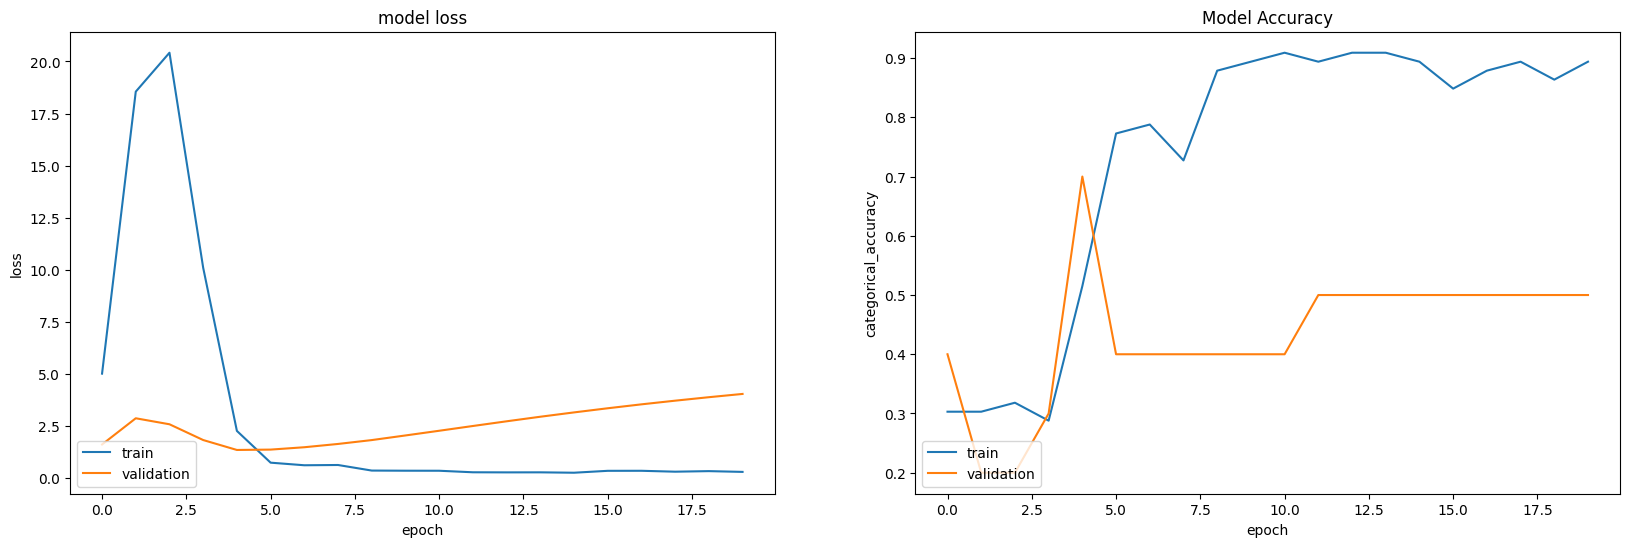

In [ ]:
plot_history(history)

### Experiment 3 (Conv3D + Augumentation)

> Result: Still Overfitting

In [ ]:
# Create generators using only 10% of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = default_batch_size, # batch size is 48
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = 10,
                                                                                      val_ablation_percentage =  10,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('conv3d_3'), LR]

In [ ]:
num_epochs = 20
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 48
Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.9291 - categorical_accuracy: 0.6212
Epoch 1: saving model to conv3d_3_2023-12-1206_18_43.466032/model-00001-0.92910-0.62121-1.45683-0.30000.h5
2/2 [==============================] - 15s 13s/step - loss: 0.9291 - categorical_accuracy: 0.6212 - val_loss: 1.4568 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.8166 - categorical_accuracy: 0.6970
Epoch 2: saving model to conv3d_3_2023-12-1206_18_43.466032/model-00002-0.81657-0.69697-1.54926-0.30000.h5
2/2 [==============================] - 20s 16s/step - loss: 0.8166 - categorical_accuracy: 0.6970 - val_loss: 1.5493 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 0.7765 - categorical_accuracy: 0.6970
Epoch 3: saving model to conv3d_3_2023-12-1206_18_43.466032/model-00003-0.77652-0.69697-1.55

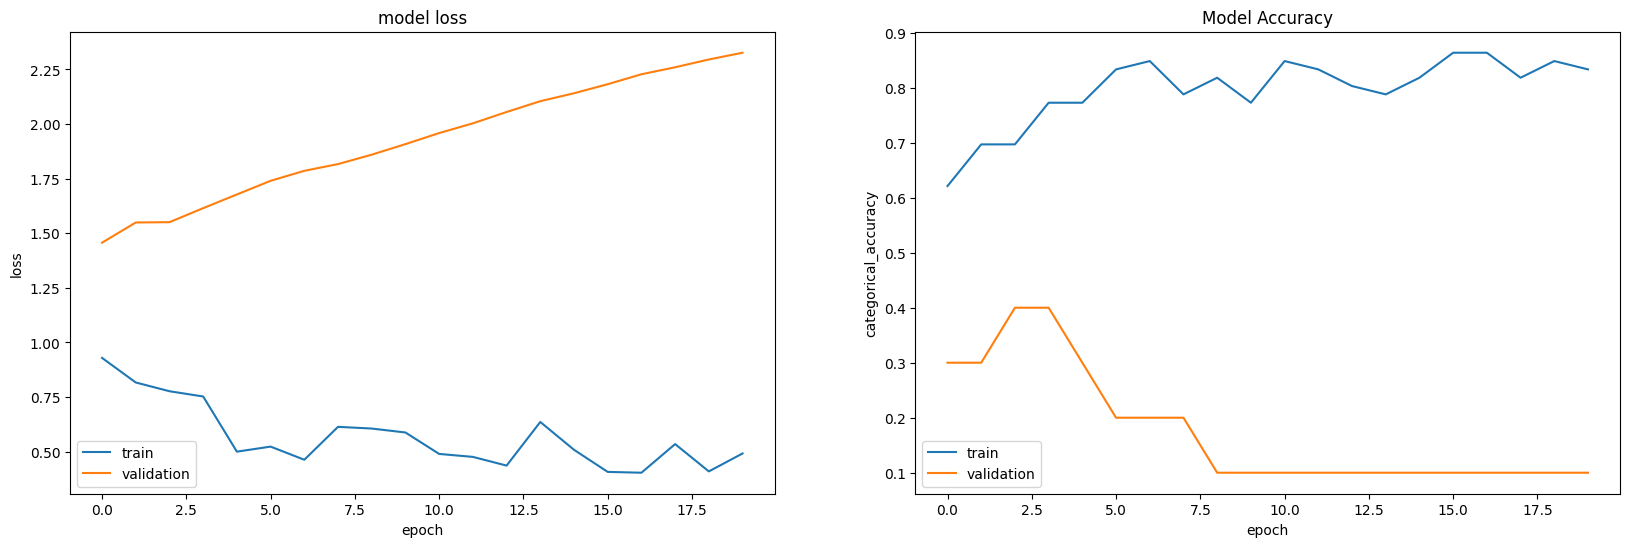

In [ ]:
plot_history(history)

### Experiment 4 (Conv3D + Augumentation + More Data)

> Result: Model overfits

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='elu', input_shape=(x,y,z,3)))
model.add(Conv3D(64, kernel_size=3, activation='elu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='elu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='elu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 118, 118, 32   2624      
                             )                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 14, 116, 116, 64   55360     
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 58, 58, 64)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 7, 58, 58, 64)     256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 58, 58, 64)     0

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Create generators using only 10% of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 32,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = 30, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('conv3d_3'), LR]

In [ ]:
num_epochs = 20
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 1.3035 - categorical_accuracy: 0.4798
Epoch 1: saving model to conv3d_3_2023-12-1207_34_54.605894/model-00001-1.30350-0.47980-1.62707-0.35000.h5
7/7 [==============================] - 48s 8s/step - loss: 1.3035 - categorical_accuracy: 0.4798 - val_loss: 1.6271 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 1.1859 - categorical_accuracy: 0.4697
Epoch 2: saving model to conv3d_3_2023-12-1207_34_54.605894/model-00002-1.18585-0.46970-1.58677-0.20000.h5
7/7 [==============================] - 40s 6s/step - loss: 1.1859 - categorical_accuracy: 0.4697 - val_loss: 1.5868 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.1602 - categorical_accuracy: 0.5404
Epoch 3: saving model to conv3d_3_2023-12-1207_34_54.605894/model-00003-1.16019-0.54040-1.59678-0.20000.h5
7/7 [==============================] - 43s 7s/step - loss: 1.1602 - categorical_accuracy: 0.5404 - val_loss: 1.5968 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - ETA: 0s - loss: 1.1046 - categorical_accuracy: 0.5303
Epoch 4: saving model to conv3d_3_2023-12-1207_34_54.605894/model-00004-1.10457-0.53030-1.57699-0.20000.h5
7/7 [==============================] - 45s 7s/step

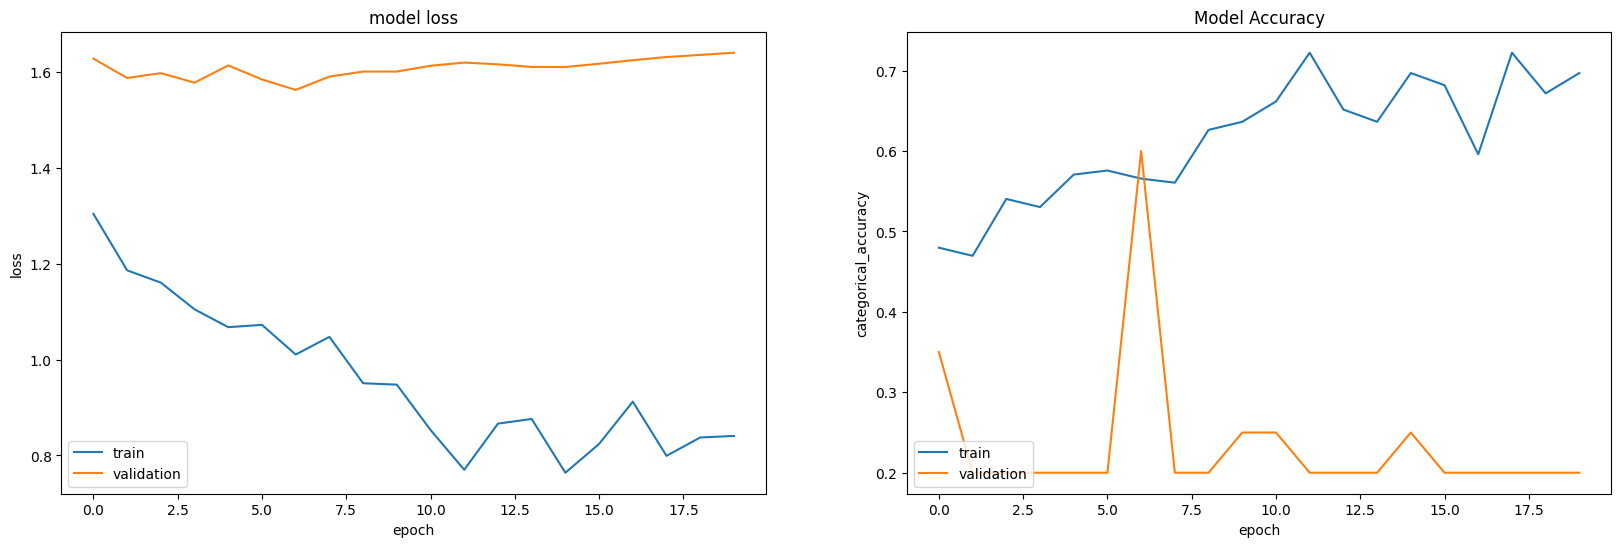

In [ ]:
plot_history(history)

### Experiment 5 (Conv3D + Augumentation + More Dropout + Full Data)

> Result: Model overfits

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='elu', input_shape=(x,y,z,3)))
model.add(Conv3D(64, kernel_size=3, activation='elu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(128, kernel_size=3, activation='elu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='elu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 118, 118, 32   2624      
                             )                                   
                                                                 
 conv3d_9 (Conv3D)           (None, 14, 116, 116, 64   55360     
                             )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 7, 58, 58, 64)     0         
 g3D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 7, 58, 58, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 7, 58, 58, 64)    

In [ ]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 32,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('conv3d_5'), LR]

In [ ]:
num_epochs = 30
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6867 - categorical_accuracy: 0.3002Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to conv3d_5_2023-12-1209_06_03.464204/model-00001-1.68674-0.30015-1.61351-0.18000.h5
21/21 [==============================] - 176s 8s/step - loss: 1.6867 - categorical_accuracy: 0.3002 - val_loss: 1.6135 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4028 - categorical_accuracy: 0.4238
Epoch 2: saving model to conv3d_5_2023-12-1209_06_03.464204/model-00002-1.40279-0.42383-1.61116-0.18000.h5
21/21 [==============================] - 144s 7s/step - loss: 1.4028 - categorical_accuracy: 0.4238 - val_loss: 1.6112 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.3380 - categorical_accuracy: 0.4374
Epoch 3: saving model to conv3d_

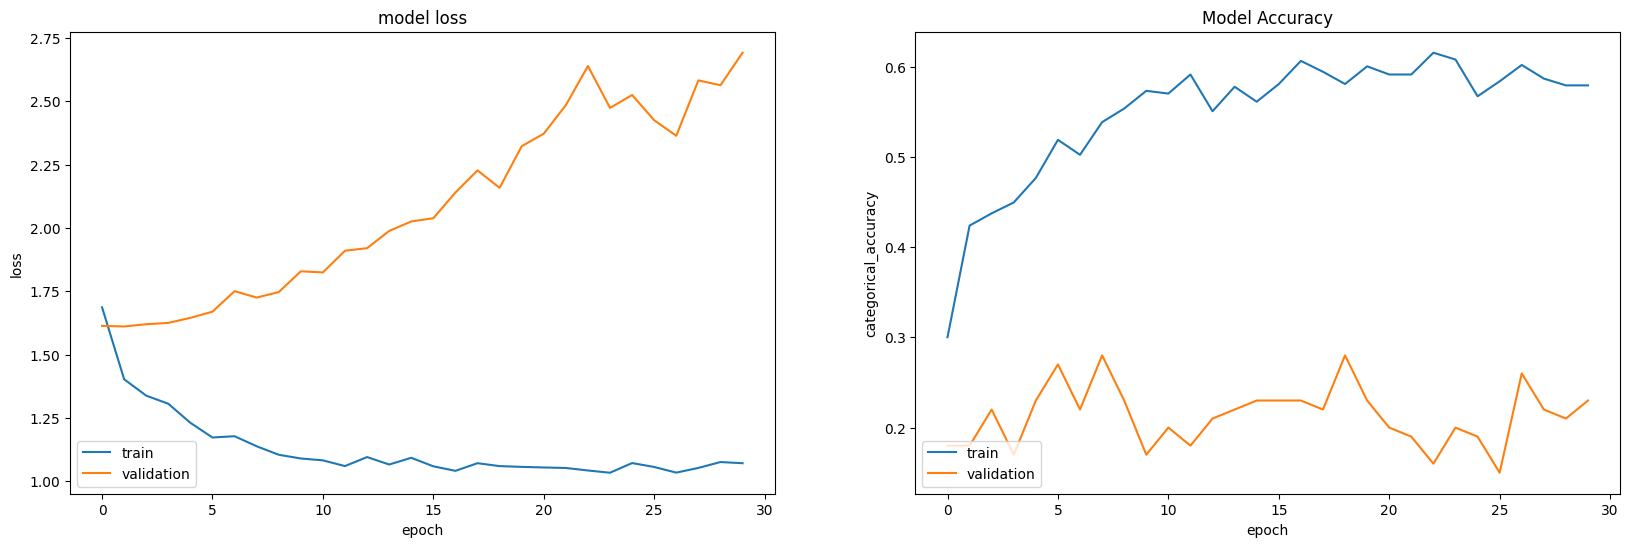

In [ ]:
plot_history(history)

### Experiment 6 (Conv3D + Augumentation + More Dropout + Full Data)

> Result: Accuracy increased

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.50))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 120, 120, 32   2624      
                             )                                   
                                                                 
 batch_normalization_4 (Bat  (None, 18, 120, 120, 32   128       
 chNormalization)            )                                   
                                                                 
 activation_4 (Activation)   (None, 18, 120, 120, 32   0         
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 9, 60, 120, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 60, 120, 64)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 32,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('conv3d_6'), LR]

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
num_epochs = 50
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 3.7775 - categorical_accuracy: 0.3062Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to conv3d_6_2023-12-1209_06_03.464204/model-00001-3.77748-0.30618-1.55484-0.26000.h5
21/21 [==============================] - 163s 7s/step - loss: 3.7775 - categorical_accuracy: 0.3062 - val_loss: 1.5548 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 1.6842 - categorical_accuracy: 0.4510
Epoch 2: saving model to conv3d_6_2023-12-1209_06_03.464204/model-00002-1.68418-0.45098-1.58426-0.37000.h5
21/21 [==============================] - 149s 7s/step - loss: 1.6842 - categorical_accuracy: 0.4510 - val_loss: 1.5843 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.3065 - categorical_accuracy: 0.5234
Epoch 3: saving model to conv3d_6_2023-12-1209_06_03.464204/model-00003-1.30651-0.52338-2.15969-0.30000.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 137s 7s/step - loss: 1.3065 - categorical_accuracy: 0.5234 - val_loss: 2.1597 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 1.0259 - categorical_accuracy: 0.6018
Epoch 4: saving model to conv3d_6_2023-12-1209_06_03.464204/model-00

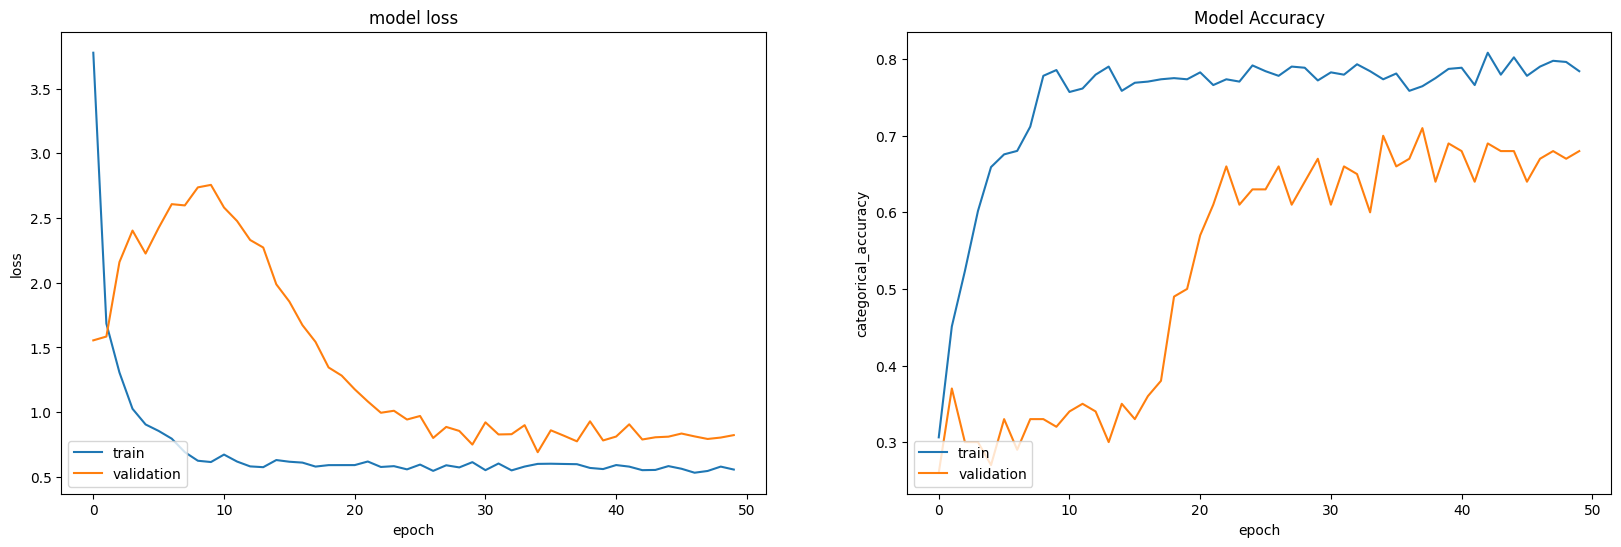

In [ ]:
plot_history(history)

Observation:
* Model accuracy increases steadily
* Model performance is still not great

### Experiment 7 (ConvLSTM2D + Conv2D)

> Result: Model performance is not satisfactory

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, Conv2D, ConvLSTM2D, GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=(x,y,z,3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(5, activation='softmax'))

In [12]:
sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 118, 118, 8)   224       
 ributed)                                                        
                                                                 
 batch_normalization (Batch  (None, 15, 118, 118, 8)   32        
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 15, 116, 116, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_1 (Bat  (None, 15, 116, 116, 16   64        
 chNormalization)            )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)       6

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 32,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('lstm_7'), LR]

In [14]:
num_epochs = 30
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6260 - categorical_accuracy: 0.2443Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to lstm_7_2023-12-1303_15_54.651629/model-00001-1.62599-0.24434-1.60607-0.28000.h5
21/21 [==============================] - 141s 6s/step - loss: 1.6260 - categorical_accuracy: 0.2443 - val_loss: 1.6061 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 1.5840 - categorical_accuracy: 0.3047
Epoch 2: saving model to lstm_7_2023-12-1303_15_54.651629/model-00002-1.58403-0.30468-1.60327-0.23000.h5
21/21 [==============================] - 125s 6s/step - loss: 1.5840 - categorical_accuracy: 0.3047 - val_loss: 1.6033 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.5655 - categorical_accuracy: 0.2790
Epoch 3: saving model to lstm_7_2023-12-1303_15_54.651629/model-00003-1.56545-0.27903-1.60409-0.22000.h5
21/21 [==============================] - 115s 6s/step - loss: 1.5655 - categorical_accuracy: 0.2790 - val_loss: 1.6041 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 1.5465 - categorical_accuracy: 0.3107
Epoch 4: saving model to lstm_7_2023-12-1303_15_54.651629/model-00004-1.54650-0.31071-1.60161-0.23000.h5
21/21 [==============================] - 106

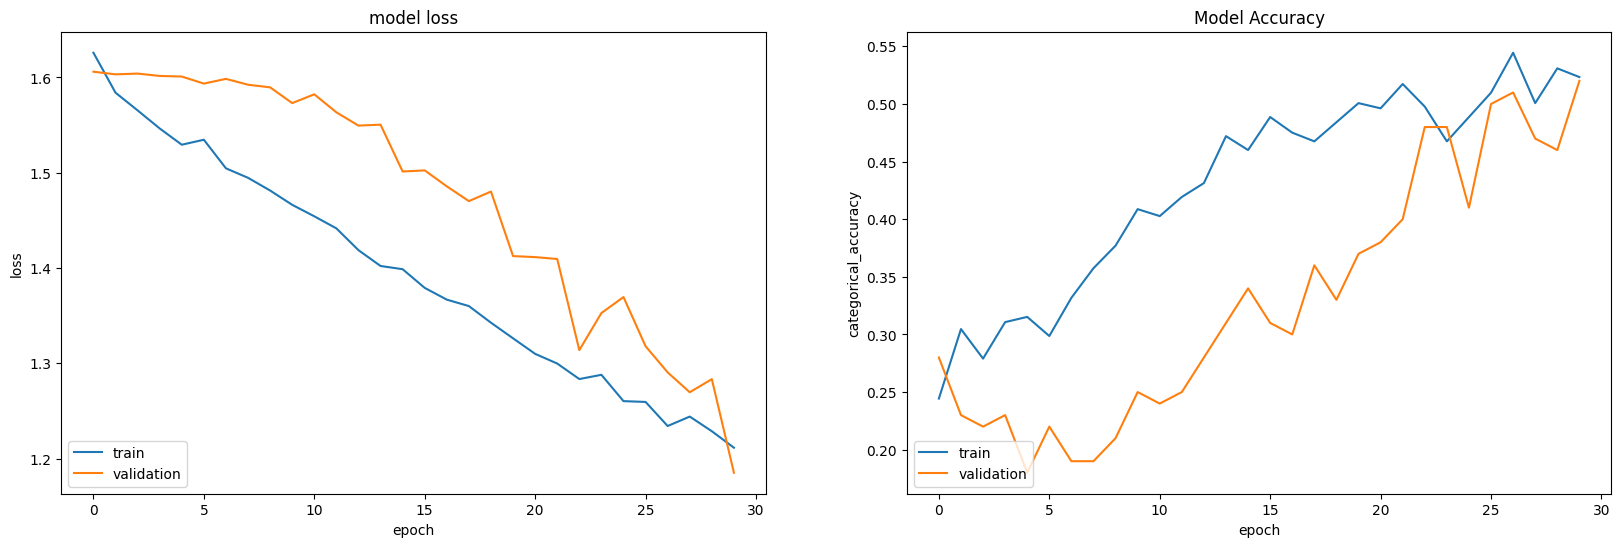

In [15]:
plot_history(history)

### Experiment 8 (ConvLSTM2D + Conv2D + Adam)

> Result: Improved performance

In [15]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, Conv2D, ConvLSTM2D, GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=(x,y,z,3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(5, activation='softmax'))

In [16]:
# sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 118, 118, 8)   224       
 ributed)                                                        
                                                                 
 batch_normalization (Batch  (None, 15, 118, 118, 8)   32        
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 15, 116, 116, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_1 (Bat  (None, 15, 116, 116, 16   64        
 chNormalization)            )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [17]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 32,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('lstm_8'), LR]

In [18]:
num_epochs = 50
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5210 - categorical_accuracy: 0.3303Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to lstm_8_2023-12-1310_06_51.306163/model-00001-1.52103-0.33032-1.60439-0.22000.h5
21/21 [==============================] - 135s 6s/step - loss: 1.5210 - categorical_accuracy: 0.3303 - val_loss: 1.6044 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 1.3365 - categorical_accuracy: 0.4827
Epoch 2: saving model to lstm_8_2023-12-1310_06_51.306163/model-00002-1.33649-0.48265-1.59881-0.21000.h5
21/21 [==============================] - 118s 6s/step - loss: 1.3365 - categorical_accuracy: 0.4827 - val_loss: 1.5988 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.1807 - categorical_accuracy: 0.5234
Epoch 3: saving model to lstm_8_2023-12-1310_06_51.306163/model-00003-1.18072-0.52338-1.62186-0.11000.h5
21/21 [==============================] - 116s 6s/step - loss: 1.1807 - categorical_accuracy: 0.5234 - val_loss: 1.6219 - val_categorical_accuracy: 0.1100 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 1.0982 - categorical_accuracy: 0.5339
Epoch 4: saving model to lstm_8_2023-12-1310_06_51.306163/model-00004-1.09816-0.53394-1.59045-0.17000.h5
21/21 [==============================] - 88s

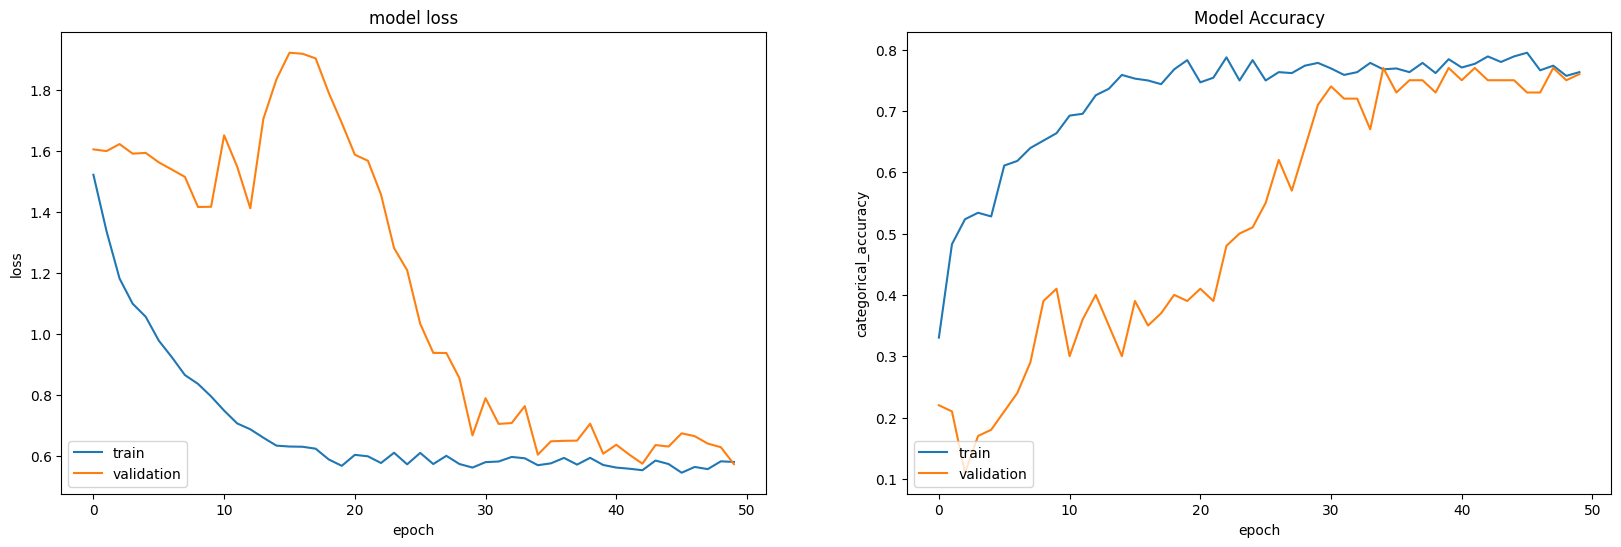

In [19]:
plot_history(history)

### Experiment 9 (VGG16 + GRU)

> Result: Performance of the model isn't satisfactory

In [399]:
from keras.models import Sequential
from keras.layers import TimeDistributed, GRU, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16

# Define the VGG16 model with pre-trained weights on ImageNet
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

# Freeze the weights of the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model for feature extraction
feature_extractor_model = Sequential()
feature_extractor_model.add(base_model)
feature_extractor_model.add(Flatten())
feature_extractor_model.add(Dense(128, activation='relu'))

# Create main model that uses the feature extractor
model = Sequential()
model.add(TimeDistributed(feature_extractor_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [400]:
sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_90 (TimeD  (None, 15, 128)           15304640  
 istributed)                                                     
                                                                 
 gru_82 (GRU)                (None, 15, 32)            15552     
                                                                 
 gru_83 (GRU)                (None, 16)                2400      
                                                                 
 dropout_74 (Dropout)        (None, 16)                0         
                                                                 
 dense_126 (Dense)           (None, 8)                 136       
                                                                 
 dense_127 (Dense)           (None, 5)                 45        
                                                     

In [401]:
x, y, z

(15, 120, 120)

In [368]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 64,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = False)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('vgg16_gru_9'), LR]

In [369]:
num_epochs = 100
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 1.7086 - categorical_accuracy: 0.2232Source path =  Project_data/val ; batch size = 64

Epoch 1: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00001-1.70861-0.22323-1.56396-0.31000.h5
11/11 [==============================] - 55s 5s/step - loss: 1.7086 - categorical_accuracy: 0.2232 - val_loss: 1.5640 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 1.6597 - categorical_accuracy: 0.2247
Epoch 2: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00002-1.65971-0.22474-1.59797-0.23000.h5
11/11 [==============================] - 42s 4s/step - loss: 1.6597 - categorical_accuracy: 0.2247 - val_loss: 1.5980 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 1.6760 - categorical_accuracy: 0.2247
Epoch 3: saving model to 

11/11 [==============================] - 46s 4s/step - loss: 1.5229 - categorical_accuracy: 0.3002 - val_loss: 1.4692 - val_categorical_accuracy: 0.3400 - lr: 2.5000e-04
Epoch 22/100
11/11 [==============================] - ETA: 0s - loss: 1.5365 - categorical_accuracy: 0.2836
Epoch 22: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00022-1.53652-0.28356-1.47722-0.35000.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
11/11 [==============================] - 42s 4s/step - loss: 1.5365 - categorical_accuracy: 0.2836 - val_loss: 1.4772 - val_categorical_accuracy: 0.3500 - lr: 2.5000e-04
Epoch 23/100
11/11 [==============================] - ETA: 0s - loss: 1.5474 - categorical_accuracy: 0.2911
Epoch 23: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00023-1.54744-0.29110-1.46363-0.35000.h5
11/11 [==============================] - 46s 4s/step - loss: 1.5474 - categorical_accuracy: 0.2911 - val_loss: 1.4636 - val_categorical_accuracy

Epoch 42/100
11/11 [==============================] - ETA: 0s - loss: 1.5411 - categorical_accuracy: 0.2971
Epoch 42: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00042-1.54109-0.29713-1.45187-0.36000.h5
11/11 [==============================] - 42s 4s/step - loss: 1.5411 - categorical_accuracy: 0.2971 - val_loss: 1.4519 - val_categorical_accuracy: 0.3600 - lr: 1.0000e-05
Epoch 43/100
11/11 [==============================] - ETA: 0s - loss: 1.5247 - categorical_accuracy: 0.3167
Epoch 43: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00043-1.52471-0.31674-1.45484-0.36000.h5
11/11 [==============================] - 47s 5s/step - loss: 1.5247 - categorical_accuracy: 0.3167 - val_loss: 1.4548 - val_categorical_accuracy: 0.3600 - lr: 1.0000e-05
Epoch 44/100
11/11 [==============================] - ETA: 0s - loss: 1.5359 - categorical_accuracy: 0.2866
Epoch 44: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00044-1.53592-0.28658-1.48198-0.34000.h5
11/

11/11 [==============================] - ETA: 0s - loss: 1.5241 - categorical_accuracy: 0.3183
Epoch 63: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00063-1.52408-0.31825-1.45187-0.37000.h5
11/11 [==============================] - 46s 4s/step - loss: 1.5241 - categorical_accuracy: 0.3183 - val_loss: 1.4519 - val_categorical_accuracy: 0.3700 - lr: 1.0000e-05
Epoch 64/100
11/11 [==============================] - ETA: 0s - loss: 1.5154 - categorical_accuracy: 0.3228
Epoch 64: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00064-1.51544-0.32278-1.42644-0.40000.h5
11/11 [==============================] - 44s 4s/step - loss: 1.5154 - categorical_accuracy: 0.3228 - val_loss: 1.4264 - val_categorical_accuracy: 0.4000 - lr: 1.0000e-05
Epoch 65/100
11/11 [==============================] - ETA: 0s - loss: 1.5182 - categorical_accuracy: 0.2986
Epoch 65: saving model to vgg16_gru_8_2023-12-1311_34_31.865366/model-00065-1.51823-0.29864-1.45151-0.37000.h5
11/11 [=========

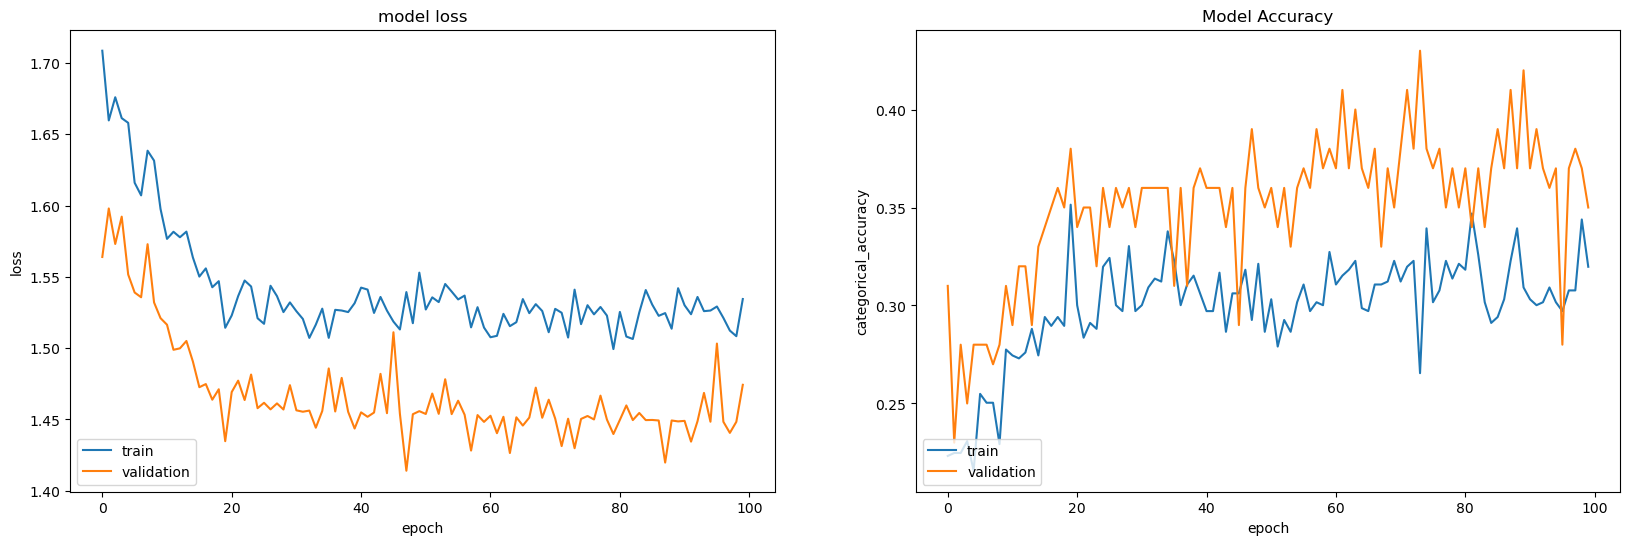

In [370]:
plot_history(history)

Best performance is at Epoch 62

### Experiment 10 (VGG16 + GRU + Adam)
Training using all VGG16 Layers

> Result: Performance of the model is good. Slightly overfitting but contains some good epoches.

In [428]:
from keras.models import Sequential
from keras.layers import TimeDistributed, GRU, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16

# Define the VGG16 model with pre-trained weights on ImageNet
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

# Freeze the weights of the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model for feature extraction
feature_extractor_model = Sequential()
feature_extractor_model.add(base_model)
feature_extractor_model.add(Flatten())
feature_extractor_model.add(Dense(256, activation='relu'))

# Create main model that uses the feature extractor
model = Sequential()
model.add(TimeDistributed(feature_extractor_model, input_shape=(x,y,z,3)))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [429]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_99 (TimeD  (None, 15, 256)           15894592  
 istributed)                                                     
                                                                 
 gru_99 (GRU)                (None, 15, 64)            61824     
                                                                 
 dropout_87 (Dropout)        (None, 15, 64)            0         
                                                                 
 gru_100 (GRU)               (None, 32)                9408      
                                                                 
 dropout_88 (Dropout)        (None, 32)                0         
                                                                 
 dense_151 (Dense)           (None, 20)                660       
                                                     

In [430]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 64,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('gru_adam_10'), LR]

In [431]:
num_epochs = 50
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.7743 - categorical_accuracy: 0.2247Source path =  Project_data/val ; batch size = 64

Epoch 1: saving model to gru_adam_10_2023-12-1315_04_55.531350/model-00001-1.77433-0.22474-1.50322-0.27000.h5
11/11 [==============================] - 57s 5s/step - loss: 1.7743 - categorical_accuracy: 0.2247 - val_loss: 1.5032 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.5777 - categorical_accuracy: 0.3002
Epoch 2: saving model to gru_adam_10_2023-12-1315_04_55.531350/model-00002-1.57773-0.30015-1.40236-0.40000.h5
11/11 [==============================] - 45s 4s/step - loss: 1.5777 - categorical_accuracy: 0.3002 - val_loss: 1.4024 - val_categorical_accuracy: 0.4000 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.4467 - categorical_accuracy: 0.3786
Epoch 3: saving model to gru

11/11 [==============================] - 48s 5s/step - loss: 0.2099 - categorical_accuracy: 0.9517 - val_loss: 0.5433 - val_categorical_accuracy: 0.8100 - lr: 1.2500e-04
Epoch 22/50
11/11 [==============================] - ETA: 0s - loss: 0.2070 - categorical_accuracy: 0.9563
Epoch 22: saving model to gru_adam_10_2023-12-1315_04_55.531350/model-00022-0.20699-0.95626-0.60700-0.78000.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
11/11 [==============================] - 44s 4s/step - loss: 0.2070 - categorical_accuracy: 0.9563 - val_loss: 0.6070 - val_categorical_accuracy: 0.7800 - lr: 1.2500e-04
Epoch 23/50
11/11 [==============================] - ETA: 0s - loss: 0.2080 - categorical_accuracy: 0.9623
Epoch 23: saving model to gru_adam_10_2023-12-1315_04_55.531350/model-00023-0.20798-0.96229-0.53977-0.80000.h5
11/11 [==============================] - 48s 5s/step - loss: 0.2080 - categorical_accuracy: 0.9623 - val_loss: 0.5398 - val_categorical_accuracy: 0

Epoch 42/50
11/11 [==============================] - ETA: 0s - loss: 0.1846 - categorical_accuracy: 0.9744
Epoch 42: saving model to gru_adam_10_2023-12-1315_04_55.531350/model-00042-0.18459-0.97436-0.42152-0.86000.h5
11/11 [==============================] - 44s 4s/step - loss: 0.1846 - categorical_accuracy: 0.9744 - val_loss: 0.4215 - val_categorical_accuracy: 0.8600 - lr: 1.0000e-05
Epoch 43/50
11/11 [==============================] - ETA: 0s - loss: 0.1916 - categorical_accuracy: 0.9593
Epoch 43: saving model to gru_adam_10_2023-12-1315_04_55.531350/model-00043-0.19156-0.95928-0.53348-0.81000.h5
11/11 [==============================] - 49s 5s/step - loss: 0.1916 - categorical_accuracy: 0.9593 - val_loss: 0.5335 - val_categorical_accuracy: 0.8100 - lr: 1.0000e-05
Epoch 44/50
11/11 [==============================] - ETA: 0s - loss: 0.1707 - categorical_accuracy: 0.9713
Epoch 44: saving model to gru_adam_10_2023-12-1315_04_55.531350/model-00044-0.17070-0.97134-0.61107-0.79000.h5
11/11 

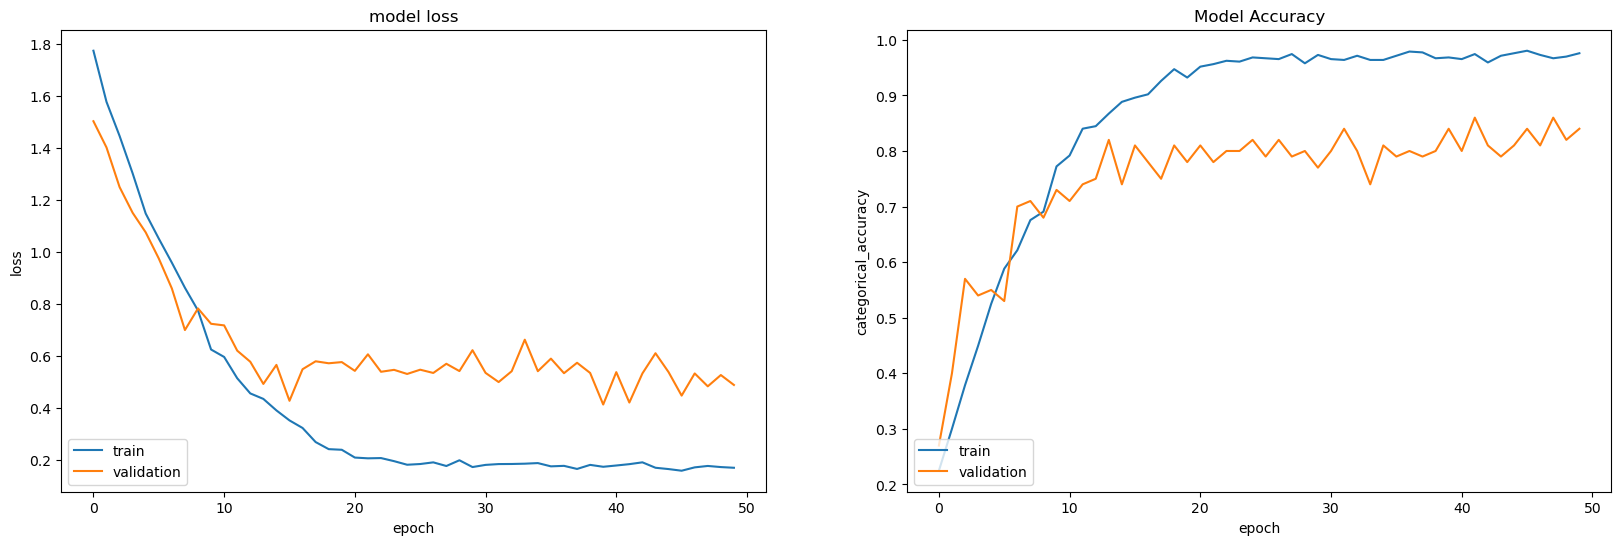

In [433]:
plot_history(history)

**Observation**:
The best-performing epoch is Epoch 42 with the following metrics:

- Categorical Accuracy: 0.9744
- Validation Loss: 0.4215
- Validation Categorical Accuracy: 0.86

### Experiment 11 (VGG16 + GRU + Adam)

> Result: Performance of the model did not improve much from Experiment 10

In [445]:
from keras.models import Sequential
from keras.layers import TimeDistributed, GRU, Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16

# Define the VGG16 model with pre-trained weights on ImageNet
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

# Freeze the weights of the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# Create a Sequential model for feature extraction
feature_extractor_model = Sequential()
feature_extractor_model.add(base_model)
feature_extractor_model.add(Flatten())
feature_extractor_model.add(Dense(192, activation='relu'))

# Create main model that uses the feature extractor
model = Sequential()
model.add(TimeDistributed(feature_extractor_model, input_shape=(x,y,z,3)))
model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(32))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [446]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_103 (Time  (None, 15, 192)           15599616  
 Distributed)                                                    
                                                                 
 gru_107 (GRU)               (None, 15, 64)            49536     
                                                                 
 dropout_94 (Dropout)        (None, 15, 64)            0         
                                                                 
 gru_108 (GRU)               (None, 32)                9408      
                                                                 
 dropout_95 (Dropout)        (None, 32)                0         
                                                                 
 dense_163 (Dense)           (None, 8)                 264       
                                                    

In [447]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 64,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = True)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('gru_adam_11'), LR]

In [448]:
num_epochs = 50
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 64
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 2.0229 - categorical_accuracy: 0.2232Source path =  Project_data/val ; batch size = 64

Epoch 1: saving model to gru_adam_11_2023-12-1315_04_55.531350/model-00001-2.02293-0.22323-1.72835-0.20000.h5
11/11 [==============================] - 56s 5s/step - loss: 2.0229 - categorical_accuracy: 0.2232 - val_loss: 1.7283 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.8075 - categorical_accuracy: 0.2519
Epoch 2: saving model to gru_adam_11_2023-12-1315_04_55.531350/model-00002-1.80746-0.25189-1.56607-0.18000.h5
11/11 [==============================] - 45s 4s/step - loss: 1.8075 - categorical_accuracy: 0.2519 - val_loss: 1.5661 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.7281 - categorical_accuracy: 0.2836
Epoch 3: saving model to gru

Epoch 42/50
11/11 [==============================] - ETA: 0s - loss: 0.6938 - categorical_accuracy: 0.7557
Epoch 42: saving model to gru_adam_11_2023-12-1315_04_55.531350/model-00042-0.69382-0.75566-0.69930-0.72000.h5
11/11 [==============================] - 44s 4s/step - loss: 0.6938 - categorical_accuracy: 0.7557 - val_loss: 0.6993 - val_categorical_accuracy: 0.7200 - lr: 1.0000e-05
Epoch 43/50
11/11 [==============================] - ETA: 0s - loss: 0.6842 - categorical_accuracy: 0.7376
Epoch 43: saving model to gru_adam_11_2023-12-1315_04_55.531350/model-00043-0.68419-0.73756-0.70546-0.77000.h5
11/11 [==============================] - 49s 5s/step - loss: 0.6842 - categorical_accuracy: 0.7376 - val_loss: 0.7055 - val_categorical_accuracy: 0.7700 - lr: 1.0000e-05
Epoch 44/50
11/11 [==============================] - ETA: 0s - loss: 0.6532 - categorical_accuracy: 0.7707
Epoch 44: saving model to gru_adam_11_2023-12-1315_04_55.531350/model-00044-0.65316-0.77074-0.70423-0.75000.h5
11/11 

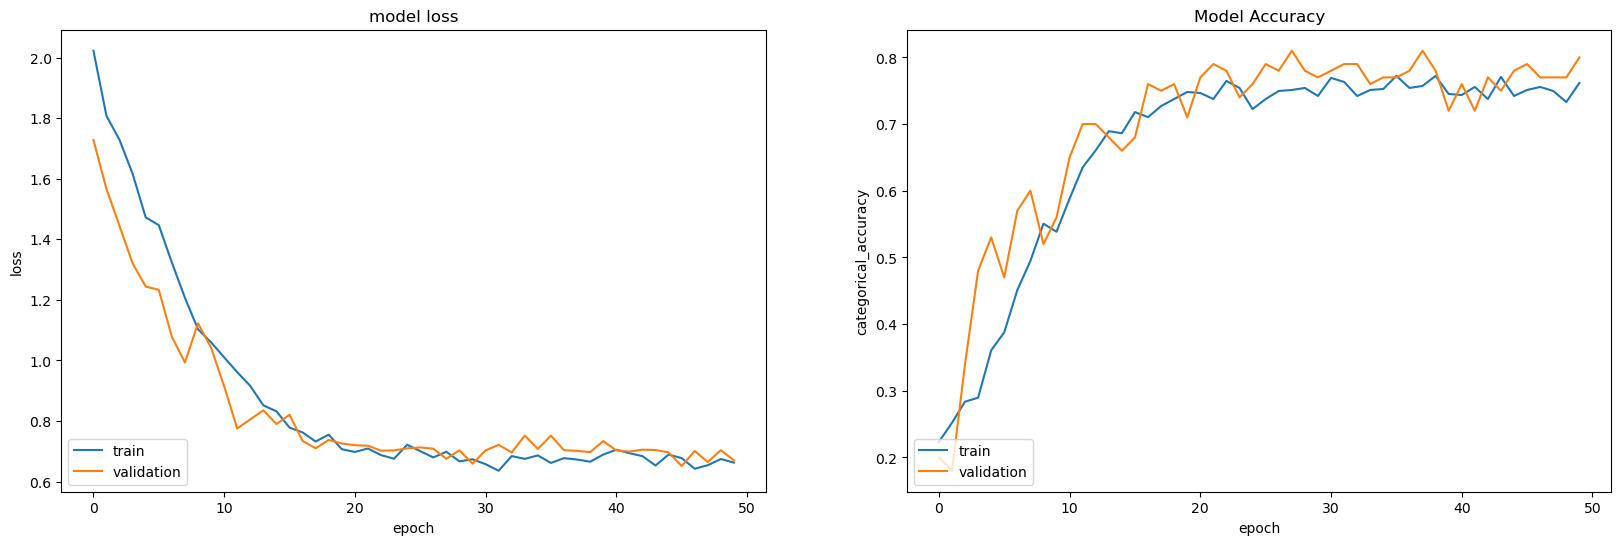

In [449]:
plot_history(history)

### Experiment 12 (VGG16 + GRU + Modify base model)
Training using all VGG16 Layers

> Result: Performance of the model is good

In [432]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

# Define the VGG16 model with pre-trained weights on ImageNet
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

# Freeze the weights of the VGG16 layers
for layer in base_model.layers:
    layer.trainable = True # Train base model layers

# Create a Sequential model for feature extraction
feature_extractor_model = Sequential()
feature_extractor_model.add(base_model)
feature_extractor_model.add(Flatten())
feature_extractor_model.add(Dense(64, activation='relu'))

# Create main model that uses the feature extractor
model = Sequential()
model.add(TimeDistributed(feature_extractor_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
sgd = optimizers.legacy.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 15, 64)            15009664  
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_7 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 5)                 45        
                                                      

In [ ]:
# Create generators using all of training and validation data
train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = 32,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = False)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                       mode="min", cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [create_checkpoint_callback('vgg16_gru_12'), LR]

In [ ]:
num_epochs = 100
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.6718 - categorical_accuracy: 0.2504Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00001-1.67179-0.25038-1.55335-0.31000.h5
21/21 [==============================] - 90s 4s/step - loss: 1.6718 - categorical_accuracy: 0.2504 - val_loss: 1.5534 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.5672 - categorical_accuracy: 0.3258
Epoch 2: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00002-1.56717-0.32579-1.49593-0.38000.h5
21/21 [==============================] - 88s 4s/step - loss: 1.5672 - categorical_accuracy: 0.3258 - val_loss: 1.4959 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.5028 - categorical_accuracy: 0.3575
Epoch 3: saving model t

Epoch 22/100
21/21 [==============================] - ETA: 0s - loss: 0.6395 - categorical_accuracy: 0.8401 
Epoch 22: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00022-0.63953-0.84012-0.72757-0.76000.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
21/21 [==============================] - 988s 49s/step - loss: 0.6395 - categorical_accuracy: 0.8401 - val_loss: 0.7276 - val_categorical_accuracy: 0.7600 - lr: 2.5000e-04
Epoch 23/100
21/21 [==============================] - ETA: 0s - loss: 0.6654 - categorical_accuracy: 0.7964
Epoch 23: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00023-0.66543-0.79638-0.73332-0.79000.h5
21/21 [==============================] - 89s 4s/step - loss: 0.6654 - categorical_accuracy: 0.7964 - val_loss: 0.7333 - val_categorical_accuracy: 0.7900 - lr: 1.2500e-04
Epoch 24/100
21/21 [==============================] - ETA: 0s - loss: 0.6649 - categorical_accuracy: 0.8130
Epoch 24: saving model to vgg16

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x2d4356da0>
    label = <none> 
    device = <AGXG14SDevice: 0x14c060200>
        name = Apple M2 Pro 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x12c438000>
        label = <none> 
        device = <AGXG14SDevice: 0x14c060200>
            name = Apple M2 Pro 
    retainedReferences = 1


21/21 [==============================] - ETA: 0s - loss: 0.6335 - categorical_accuracy: 0.8220 
Epoch 25: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00025-0.63346-0.82202-0.73182-0.81000.h5
21/21 [==============================] - 1084s 54s/step - loss: 0.6335 - categorical_accuracy: 0.8220 - val_loss: 0.7318 - val_categorical_accuracy: 0.8100 - lr: 6.2500e-05
Epoch 26/100
21/21 [==============================] - ETA: 0s - loss: 0.6120 - categorical_accuracy: 0.8386
Epoch 26: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00026-0.61202-0.83861-0.73030-0.81000.h5

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
21/21 [==============================] - 89s 4s/step - loss: 0.6120 - categorical_accuracy: 0.8386 - val_loss: 0.7303 - val_categorical_accuracy: 0.8100 - lr: 6.2500e-05
Epoch 27/100
21/21 [==============================] - ETA: 0s - loss: 0.6347 - categorical_accuracy: 0.8084
Epoch 27: saving model to vgg16_gru_12_2023

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x2d775ffc0>
    label = <none> 
    device = <AGXG14SDevice: 0x14c060200>
        name = Apple M2 Pro 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x12c438000>
        label = <none> 
        device = <AGXG14SDevice: 0x14c060200>
            name = Apple M2 Pro 
    retainedReferences = 1


21/21 [==============================] - ETA: 0s - loss: 0.6174 - categorical_accuracy: 0.8386 
Epoch 35: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00035-0.61743-0.83861-0.71615-0.81000.h5
21/21 [==============================] - 882s 44s/step - loss: 0.6174 - categorical_accuracy: 0.8386 - val_loss: 0.7162 - val_categorical_accuracy: 0.8100 - lr: 1.0000e-05
Epoch 36/100
21/21 [==============================] - ETA: 0s - loss: 0.6208 - categorical_accuracy: 0.8341
Epoch 36: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00036-0.62077-0.83409-0.76010-0.77000.h5
21/21 [==============================] - 87s 4s/step - loss: 0.6208 - categorical_accuracy: 0.8341 - val_loss: 0.7601 - val_categorical_accuracy: 0.7700 - lr: 1.0000e-05
Epoch 37/100
21/21 [==============================] - ETA: 0s - loss: 0.5998 - categorical_accuracy: 0.8477
Epoch 37: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00037-0.59979-0.84766-0.72553-0.81000.h5
21/21 [===

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x3c5eb5060>
    label = <none> 
    device = <AGXG14SDevice: 0x14c060200>
        name = Apple M2 Pro 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x12c438000>
        label = <none> 
        device = <AGXG14SDevice: 0x14c060200>
            name = Apple M2 Pro 
    retainedReferences = 1


21/21 [==============================] - ETA: 0s - loss: 0.6188 - categorical_accuracy: 0.8250
Epoch 52: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00052-0.61878-0.82504-0.70065-0.82000.h5
21/21 [==============================] - 91s 4s/step - loss: 0.6188 - categorical_accuracy: 0.8250 - val_loss: 0.7007 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-05
Epoch 53/100
21/21 [==============================] - ETA: 0s - loss: 0.6295 - categorical_accuracy: 0.8311
Epoch 53: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00053-0.62950-0.83107-0.70218-0.84000.h5
21/21 [==============================] - 91s 4s/step - loss: 0.6295 - categorical_accuracy: 0.8311 - val_loss: 0.7022 - val_categorical_accuracy: 0.8400 - lr: 1.0000e-05
Epoch 54/100
15/21 [====================>.........] - ETA: 21s - loss: 0.6191 - categorical_accuracy: 0.8354

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x2d4351400>
    label = <none> 
    device = <AGXG14SDevice: 0x14c060200>
        name = Apple M2 Pro 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x12c438000>
        label = <none> 
        device = <AGXG14SDevice: 0x14c060200>
            name = Apple M2 Pro 
    retainedReferences = 1


21/21 [==============================] - ETA: 0s - loss: 0.6139 - categorical_accuracy: 0.8371
Epoch 54: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00054-0.61393-0.83710-0.71073-0.82000.h5
21/21 [==============================] - 88s 4s/step - loss: 0.6139 - categorical_accuracy: 0.8371 - val_loss: 0.7107 - val_categorical_accuracy: 0.8200 - lr: 1.0000e-05
Epoch 55/100
21/21 [==============================] - ETA: 0s - loss: 0.5936 - categorical_accuracy: 0.8492
Epoch 55: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00055-0.59363-0.84917-0.71660-0.81000.h5
21/21 [==============================] - 89s 4s/step - loss: 0.5936 - categorical_accuracy: 0.8492 - val_loss: 0.7166 - val_categorical_accuracy: 0.8100 - lr: 1.0000e-05
Epoch 56/100
21/21 [==============================] - ETA: 0s - loss: 0.6057 - categorical_accuracy: 0.8567
Epoch 56: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00056-0.60572-0.85671-0.70247-0.82000.h5
21/21 [======

21/21 [==============================] - ETA: 0s - loss: 0.5881 - categorical_accuracy: 0.8582
Epoch 96: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00096-0.58806-0.85822-0.71738-0.77000.h5
21/21 [==============================] - 89s 4s/step - loss: 0.5881 - categorical_accuracy: 0.8582 - val_loss: 0.7174 - val_categorical_accuracy: 0.7700 - lr: 1.0000e-05
Epoch 97/100
21/21 [==============================] - ETA: 0s - loss: 0.5909 - categorical_accuracy: 0.8356
Epoch 97: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00097-0.59093-0.83560-0.70474-0.81000.h5
21/21 [==============================] - 88s 4s/step - loss: 0.5909 - categorical_accuracy: 0.8356 - val_loss: 0.7047 - val_categorical_accuracy: 0.8100 - lr: 1.0000e-05
Epoch 98/100
21/21 [==============================] - ETA: 0s - loss: 0.5896 - categorical_accuracy: 0.8492
Epoch 98: saving model to vgg16_gru_12_2023-12-1300_17_31.037646/model-00098-0.58958-0.84917-0.72020-0.79000.h5
21/21 [======

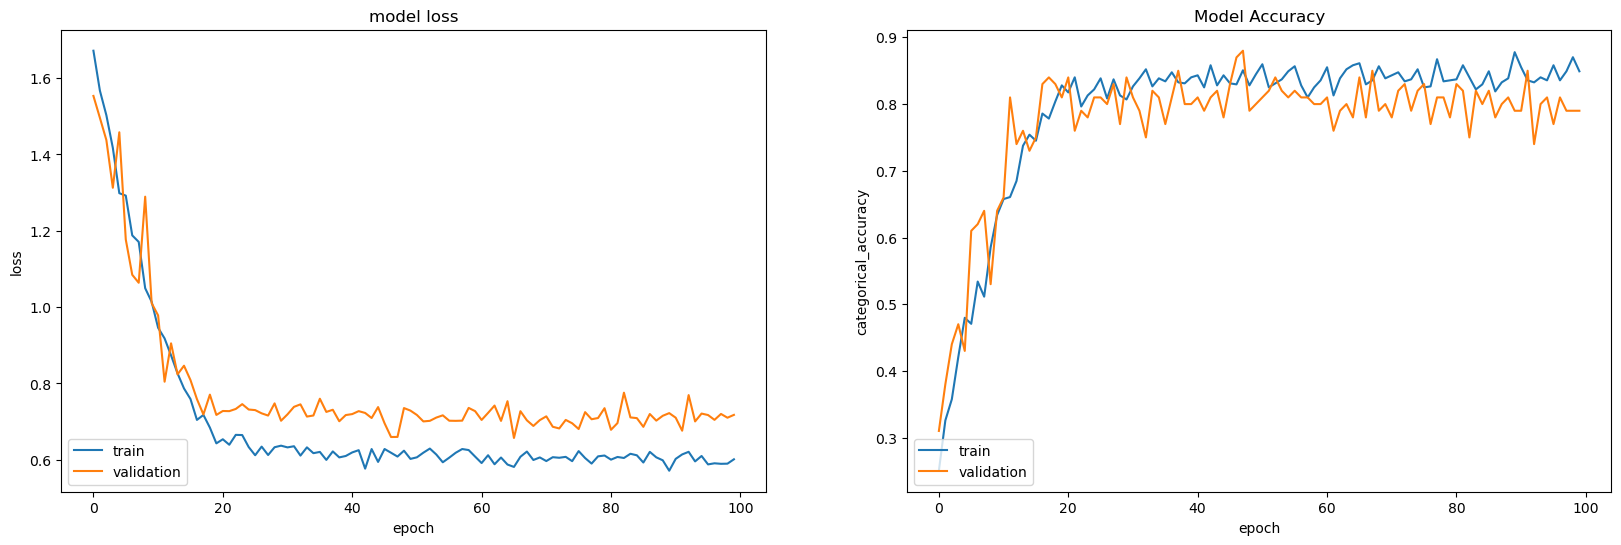

In [ ]:
plot_history(history)

**Observation**:
The best-performing epoch is Epoch 48 with the following metrics:

- Categorical Accuracy: 0.8507
- Validation Loss: 0.66
- Validation Categorical Accuracy: 0.88

### Final Model and Test Accuracy

Selecting **Epoch 42** of **Experiment 10** as the final model: **model-00042-0.18459-0.97436-0.42152-0.86000.h5**

In [21]:
from keras.models import load_model, Model
selected_model_file = "model-00042-0.18459-0.97436-0.42152-0.86000.h5"

model = load_model(selected_model_file)
model_func = Model(inputs=[model.input], outputs=[model.output])

batch_size = 32

train_generator, val_generator, steps_per_epoch, validation_steps = create_generators(batch_size = batch_size,
                                                                                      img_height = y,
                                                                                      img_width = z,
                                                                                      train_ablation_percentage = None, # Use more data than before
                                                                                      val_ablation_percentage =  None,
                                                                                      should_augument_images = False)
num_correct_pred = 0
for i in range(validation_steps):
    data,labels = next(val_generator)
    pred_idx = np.argmax(model_func.predict_on_batch(data), axis=1)
    for j,k in enumerate(pred_idx):
        if labels[j,k] == 1:
            num_correct_pred += 1
print(f'Final model has Test Accuracy of {num_correct_pred*100/num_val_sequences}%')

Source path =  Project_data/val ; batch size = 32
Final model has Test Accuracy of 80.0%


>Final model has Test Accuracy of 80.0%